# TODO


* Check BF's and effect sizes using weaker/stronger priors (probably won't have any effect here, except maybe for max-d in mouse data with CoMs)
* Calculate BF's using ten independent fits (would take 10x time, only do when finalizing the paper submission)
* Refactor code so that every "result" has a proper name (e.g., mt_max_d_bf_result)
* Save all results to RData

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Lambda$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 

# Contents

* [Preregistered analysis](#prereg)
  * [Mouse-tracking task](#mouse) 
    * [Max-d](#mouse_max_d)
    * [Response time](#mouse_RT)
  * [Walking task](#walking) 
    * [Max-d](#walking_max_d)
    * [Response time](#walking_RT)
  * [Effect of changes-of-mind](#com)
    * [Mouse-tracking](#com_mouse)
    * [Walking](#com_walking)
  * [Frequentist regressions](#freq)
* [Exploratory analysis](#explore)

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(diptest)

# data_path = "../data/choices_processed.txt"
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
figure_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures"

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

Load processed data

In [2]:
get_processed_data <- function(data_path){
    filename <- file.path(data_path, "choices_processed.txt")
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, "subj_id"] <- as.factor(data[, "subj_id"])
    data[, "option_chosen"] <- as.factor(data[, "option_chosen"])
    
    return(data)
}

In [3]:
data <- get_processed_data(data_path)
mouse_data <- data[data$task=="mouse",]
walking_data <- data[data$task=="walking",]

# Preregistered analysis <a class="anchor" id="prereg"></a>

Define the functions used throughout the notebook

In [8]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter))
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior)
    }
    return(model)
}

run_analysis <- function(var, data, rscale){
    " This function runs our analysis for a particular dataset (fake or real) and given DV (var).
    The rscale parameter defines the scale of prior distribution on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, var])/sd(data[, 'Lambda'])), class = "b"))

    formulas <- list(f_inter = as.formula(paste(var, "~ (option_chosen | subj_id) + Lambda:option_chosen")),
                     f_choice = as.formula(paste(var, "~ (option_chosen | subj_id)")),
                     f_null = as.formula(paste(var, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    return(bf_result)
}

spaghetti_plot <- function(model, var, ylabel, file_name){
    options(repr.plot.width=8, repr.plot.height=8)
    plt <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=800), plot=FALSE)
    plt <- plt$"Lambda:option_chosen" + 
#         geom_point(aes_string(x="Lambda", y=var, shape='choice', colour='choice'), size = 3, alpha=0.6, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX("Advantage of LL option ($\\lambda$)")) +
        ylab(ylabel) +
        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)
    
#     png(file.path(figure_path, file_name))
#     plot(plt_dat)
#     dev.off()
    
    ggsave(file.path(figure_path, file_name), dpi=150) 
}

joyplot <- function(model, file_name){
    options(repr.plot.width=4, repr.plot.height=8)
    m <- as.matrix(as.mcmc(model, combine_chains = FALSE))

    # Only keep the choice-by-lambda interaction parameters    
    m <- m[,grep(",option_chosen", colnames(m))]
    
    # Reformat column names
    colnames(m) <- sub("r_subj_id\\[", "s", colnames(m))
    colnames(m) <- sub(",option_chosenss]", "", colnames(m))
    
    # Reorder columns(parameters) by their mean values and plot the result        
    plt <- mcmc_areas_ridges(m[,order(colMeans(m))])#, prob=0.95)
    
    plt <- plt + theme_pander(base_size = 12) +
        xlab("Offset of regression coefficient for SS choices") #+
#         scale_color_manual(values = c("#D55E00", "#0072B2"), guide = "none")
#     +
#        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)
    ggsave(file.path(figure_path, file_name), dpi=150)
}

posterior_plot <- function(model, file_name){
    options(repr.plot.width=4, repr.plot.height=4)
    
    plot <- mcmc_areas_ridges(as.matrix(as.mcmc(model, combine_chains = TRUE)), 
                              regex_pars = "b_Lambda:option_chosen", prob=0.95)
    ggsave(file.path(figure_path, file_name), dpi=150)
    
    ci_mouse_max_d <- HPDinterval(as.mcmc(model, combine_chains = TRUE))
    print(ci_mouse_max_d[c('b_Lambda:option_chosenll', 'b_Lambda:option_chosenss'),])
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), file=file.path("csv", file_name), row.names=FALSE)
}

## Mouse-tracking task<a class="anchor" id="mouse"></a>

### Mouse-tracking task: max-d<a class="anchor" id="mouse_max_d"></a>

In [5]:
mouse_max_d_bf <- run_analysis('max_d', mouse_data, 0.707)
# mouse_max_d_bf_narrow_prior <- run_analysis("max_d", mouse_data, 0.5)
# mouse_max_d_bf_wide_prior <- run_analysis("max_d", mouse_data, 1.0)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 31.102 seconds (Warm-up)
               24.17 seconds (Sampling)
               55.272 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
A

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 18.924 seconds (Warm-up)
               9.978 seconds (Sampling)
               28.902 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 5.011 seconds (Warm-up)
               2.989 seconds (Sampling)
               8 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

In [6]:
mouse_max_d_bf$bf

3.316738e+74,2.7681e+75,7.228917


In [10]:
spaghetti_plot(mouse_max_d_bf$models$m_inter, "max_d", "max-d", "spaghetti_mouse_max_d.png")
joyplot(mouse_max_d_bf$models$m_inter, "joy_mouse_max_d.png")
posterior_plot(mouse_max_d_bf$models$m_inter, file_name = "posterior_mouse_max_d.png")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


                              lower     upper
b_Lambda:option_chosenll -11.108248 -3.925846
b_Lambda:option_chosenss  -2.169291  4.694507


In [11]:
save_posterior(mouse_max_d_bf$models$m_inter, file_name = "posterior_mouse_max_d.csv")

### Mouse-tracking task: response time<a class="anchor" id="mouse_RT"></a>

In [12]:
mouse_RT_bf <- run_analysis('RT', mouse_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 29.806 seconds (Warm-up)
               35.08 seconds (Sampling)
               64.886 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
A

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 16.862 seconds (Warm-up)
               16.361 seconds (Sampling)
               33.223 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 5.183 seconds (Warm-up)
               4.777 seconds (Sampling)
               9.96 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust yo

In [13]:
mouse_RT_bf$bf

103464174,2.835261e+19,290600650559


In [14]:
spaghetti_plot(mouse_RT_bf$models$m_inter, "RT", "RT", "spaghetti_mouse_RT.png")
joyplot(mouse_RT_bf$models$m_inter, "joy_mouse_RT.png")
posterior_plot(mouse_RT_bf$models$m_inter, file_name = "posterior_mouse_RT.png")
save_posterior(mouse_RT_bf$models$m_inter, file_name = "posterior_mouse_RT.csv")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


                               lower       upper
b_Lambda:option_chosenll -0.15519130 -0.07803341
b_Lambda:option_chosenss  0.06912803  0.12798156


## Walking<a class="anchor" id="walking"></a>

### Walking task: max-d<a class="anchor" id="walking_max_d"></a>

In [15]:
walking_max_d_bf <- run_analysis('max_d', walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.004 seconds
1000 transitions using 10 leapfrog steps per transition would take 40 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 43.059 seconds (Warm-up)
               12.624 seconds (Sampling)
               55.683 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 26.499 seconds (Warm-up)
               13.26 seconds (Sampling)
               39.759 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 9.77 seconds (Warm-up)
               5.897 seconds (Sampling)
               15.667 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

In [16]:
walking_max_d_bf$bf

9.260927e+67,2.092275e+76,224598870


In [17]:
spaghetti_plot(walking_max_d_bf$models$m_inter, "max_d", "max-d", "spaghetti_walking_max_d.png")
joyplot(walking_max_d_bf$models$m_inter, "joy_walking_max_d.png")
posterior_plot(walking_max_d_bf$models$m_inter, file_name = "posterior_walking_max_d.png")
save_posterior(walking_max_d_bf$models$m_inter, file_name = "posterior_walking_max_d.csv")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


                                lower       upper
b_Lambda:option_chosenll -0.011701654 -0.00474456
b_Lambda:option_chosenss  0.005681684  0.01246187


### Walking task: response time<a class="anchor" id="walking_RT"></a>

In [18]:
walking_rt_bf <- run_analysis('RT', walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 42.898 seconds (Warm-up)
               43.116 seconds (Sampling)
               86.014 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 32.867 seconds (Warm-up)
               20.014 seconds (Sampling)
               52.881 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 8.557 seconds (Warm-up)
               5.553 seconds (Sampling)
               14.11 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

In [19]:
walking_rt_bf$bf

205400621462,7.480984e+15,33062.97


In [20]:
spaghetti_plot(walking_rt_bf$models$m_inter, "RT", "RT", "spaghetti_walking_RT.png")
joyplot(walking_rt_bf$models$m_inter, "joy_walking_RT.png")
posterior_plot(walking_rt_bf$models$m_inter, file_name = "posterior_walking_RT.png")
save_posterior(walking_rt_bf$models$m_inter, file_name = "posterior_walking_RT.csv")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


                               lower       upper
b_Lambda:option_chosenll -0.05636347 -0.01678482
b_Lambda:option_chosenss  0.02591530  0.06427050


## Effect of changes-of-mind on max-d analysis<a class="anchor" id="com"></a>

Checking for unimodality of the max-d distributions

In [21]:
print(dip.test(mouse_data$max_d, simulate.p.value = TRUE))
print(dip.test(walking_data$max_d, simulate.p.value = TRUE))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  mouse_data$max_d
D = 0.0052932, p-value = 0.967
alternative hypothesis: non-unimodal, i.e., at least bimodal


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  walking_data$max_d
D = 0.0061884, p-value = 0.843
alternative hypothesis: non-unimodal, i.e., at least bimodal



Hartigans' dip test doesn't provide evidence in favor of multimodality. Still, the histograms of max-d for the walking task reveal that there are at least two distinct clusters of trajectories. For this reason, we check the robustness of the max-d analysis using a subset of trajectories which exclude changes-of-mind (CoM; see preprocessing notebook for a criterion used to detect CoMs)

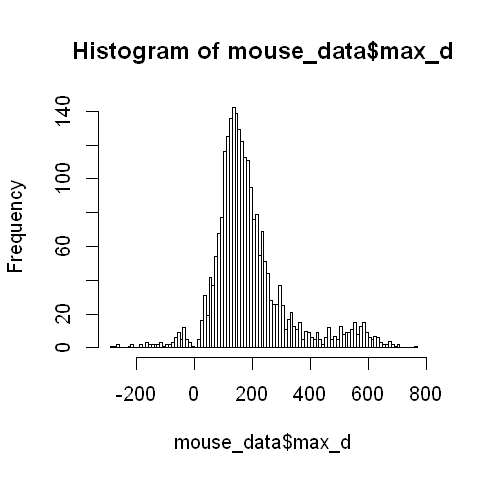

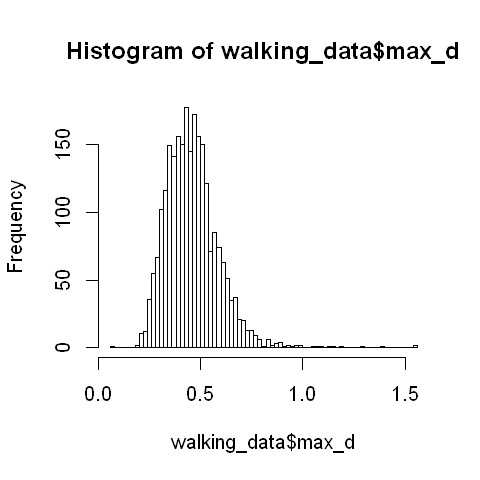

In [22]:
hist(mouse_data$max_d, breaks = 100, freq = TRUE)
hist(walking_data$max_d, breaks = 100, freq = TRUE)

In [23]:
mouse_data_no_com <- mouse_data[mouse_data$is_com=='False',]
walking_data_no_com <- walking_data[walking_data$is_com=='False',]

### Effects of CoM: mouse-tracking task<a class="anchor" id="mouse_com"></a>

In [27]:
mouse_max_d_no_com_bf <- run_analysis('max_d', mouse_data_no_com, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 21.193 seconds (Warm-up)
               16.037 seconds (Sampling)
               37.23 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
A

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 24.234 seconds (Warm-up)
               14.552 seconds (Sampling)
               38.786 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 5.831 seconds (Warm-up)
               3.709 seconds (Sampling)
               9.54 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust yo

In [28]:
mouse_max_d_no_com_bf$bf

9.364621e+58,3.431517e+56,0.004146841


In [32]:
spaghetti_plot(mouse_max_d_no_com_bf$models$m_inter, "RT", "RT", "spaghetti_mouse_max_d_no_com.png")
joyplot(mouse_max_d_no_com_bf$models$m_inter, "joy_mouse_max_d_no_com.png")
posterior_plot(mouse_max_d_no_com_bf$models$m_inter, file_name = "posterior_mouse_max_d_no_com.png")
save_posterior(mouse_max_d_no_com_bf$models$m_inter, file_name = "posterior_mouse_max_d_no_com.csv")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


                              lower    upper
b_Lambda:option_chosenll -2.9063657 1.420003
b_Lambda:option_chosenss -0.1935696 3.855119


### Effects of CoM: walking task<a class="anchor" id="walking_com"></a>

In [33]:
walking_max_d_no_com_bf <- run_analysis('max_d', walking_data_no_com, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.002 seconds
1000 transitions using 10 leapfrog steps per transition would take 20 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 47.51 seconds (Warm-up)
               21.776 seconds (Sampling)
               69.286 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 secon

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 31.189 seconds (Warm-up)
               9.919 seconds (Sampling)
               41.108 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 9.309 seconds (Warm-up)
               5.23 seconds (Sampling)
               14.539 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adj

In [34]:
walking_max_d_no_com_bf$bf

3.508443e+58,4.618727e+66,126963626


In [37]:
spaghetti_plot(walking_max_d_no_com_bf$models$m_inter, "RT", "RT", "spaghetti_walking_max_d_no_com.png")
joyplot(walking_max_d_no_com_bf$models$m_inter, "joy_walking_max_d_no_com.png")
posterior_plot(walking_max_d_no_com_bf$models$m_inter, file_name = "posterior_walking_max_d_no_com.png")
save_posterior(walking_max_d_no_com_bf$models$m_inter, file_name = "posterior_walking_max_d_no_com.csv")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


                                lower        upper
b_Lambda:option_chosenll -0.009056015 -0.003147162
b_Lambda:option_chosenss  0.005781693  0.011545299


## Frequentist regressions<a class="anchor" id="freq"></a>

Just to check whether the results of Bayesian regressions are consistent with their frequentist counterparts. In all cases (max-d/RT, mouse/walking), the models involving choice-by-$\Lambda$ interaction are most supported by the data. However, in mouse data without changes-of-mind, the choice-only model is most likely.

In [38]:
library(coin)
library(lme4)
library(lmerTest)
library(plyr)
library(xtable)
library(LMERConvenienceFunctions)
library(car)

Warning message:
"package 'coin' was built under R version 3.5.2"Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:brms':

    kidney


Attaching package: 'lme4'

The following object is masked from 'package:brms':

    ngrps

The following object is masked from 'package:gmm':

    checkConv

Warning message:
"package 'lmerTest' was built under R version 3.5.2"
Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step


Attaching package: 'xtable'

The following objects are masked from 'package:mefa':

    label, label<-

Loading required package: carData


### Mouse-tracking task: response time

In [39]:
rt_mouse_analysis <- function(stats.df){
    choice.mer = lmer(RT ~ (option_chosen | subj_id) + option_chosen:Lambda, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name ="RT_vs_lambda_mouse.tex"
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:freq_RT_vs_lambda_mouse",
                 caption = 'Response time as a function of $\\Lambda$ and choice'), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}


In [40]:
rt_mouse_analysis(mouse_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: 6915.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5887 -0.5512 -0.1424  0.3361  4.7824 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     1.7439   1.3206        
          option_chosenss 1.0786   1.0385   -0.86
 Residual                 0.8244   0.9079        
Number of obs: 2490, groups:  subj_id, 54

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               2.49865    0.09939   59.48934  25.141  < 2e-16 ***
option_chosenll:Lambda   -0.11765    0.01571  816.93829  -7.487 1.83e-13 ***
option_chosenss:Lambda    0.09829    0.01520 2448.77720   6.468 1.19e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           

### Mouse-tracking task: max-d

In [41]:
max_d_mouse_analysis <- function(stats.df){
    choice.mer = lmer(max_d ~ (option_chosen | subj_id) + option_chosen:Lambda, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name ="max_d_vs_lambda_mouse.tex"
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:freq_max_d_vs_lambda_mouse",
                 caption = 'Maximum deviation as a function of $\\Lambda$ and choice'), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}

In [42]:
max_d_mouse_analysis(mouse_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: max_d ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: 30403.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7935 -0.4694 -0.1030  0.2642  6.3501 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     10241    101.2         
          option_chosenss 15225    123.4    -0.64
 Residual                 10392    101.9         
Number of obs: 2490, groups:  subj_id, 54

Fixed effects:
                       Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)             217.597     11.492   65.150  18.935  < 2e-16 ***
option_chosenll:Lambda   -7.714      1.779 1130.646  -4.337 1.58e-05 ***
option_chosenss:Lambda    1.357      1.713 2445.162   0.792    0.428    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
             (Intr) opt

The effect of $\Lambda$ on max-d is significant, but only for LL choices. Now try excluding changes-of-mind

In [43]:
max_d_mouse_analysis(mouse_data_no_com)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: max_d ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: 25298.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9180 -0.5258 -0.0488  0.4635  7.7613 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     4767     69.04         
          option_chosenss 4332     65.82    -0.59
 Residual                 3668     60.57         
Number of obs: 2263, groups:  subj_id, 54

Fixed effects:
                        Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)             165.5175     7.9964   59.6225   20.70   <2e-16 ***
option_chosenll:Lambda   -0.6945     1.1023  778.3086   -0.63   0.5288    
option_chosenss:Lambda    1.7539     1.0442 2219.8832    1.68   0.0932 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
             (I

The frequentist analysis is consistent with the findings of Bayesian regressions. In the mouse task, the effect of $\Lambda$ on max-d is significant for the LL option, but there is no evidence of effect if we exclude changes-of-mind

### Walking data: response times

In [44]:
rt_walking_analysis <- function(stats.df){
    choice.mer = lmer(RT ~ (option_chosen | subj_id) + option_chosen:Lambda, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name ="RT_vs_lambda_walking.tex"
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:freq_RT_vs_lambda_walking",
                 caption = 'Response time as a function of $\\Lambda$ and choice'), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}


In [45]:
rt_walking_analysis(walking_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: 4450.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6080 -0.6300 -0.1584  0.4395  6.3999 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     0.6713   0.8194        
          option_chosenss 0.1868   0.4322   -0.49
 Residual                 0.3118   0.5584        
Number of obs: 2451, groups:  subj_id, 54

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             4.845e+00  9.925e-02  5.572e+01  48.812  < 2e-16 ***
option_chosenll:Lambda -3.460e-02  8.718e-03  4.212e+02  -3.969 8.49e-05 ***
option_chosenss:Lambda  4.461e-02  9.650e-03  2.388e+03   4.622 4.00e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           

### Walking task: max-d

In [46]:
max_d_walking_analysis <- function(stats.df){
    choice.mer = lmer(max_d ~ (option_chosen | subj_id) + option_chosen:Lambda, stats.df)
    print(summary(choice.mer))

    choice.output = summary(choice.mer)$coefficients

    file_name ="max_d_vs_lambda_walking.tex"
    print(xtable(choice.output, digits = c(2,2,2,2,2,-2), 
                 label = "tab:freq_max_d_vs_lambda_mouse",
                 caption = 'Maximum deviation as a function of $\\Lambda$ and choice'), 
          math.style.exponents = TRUE, type = "latex", file = file_name)
}

In [47]:
max_d_walking_analysis(walking_data)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: max_d ~ (option_chosen | subj_id) + option_chosen:Lambda
   Data: stats.df

REML criterion at convergence: -4023.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6272 -0.5803 -0.0822  0.4605 10.1332 

Random effects:
 Groups   Name            Variance Std.Dev. Corr 
 subj_id  (Intercept)     0.008278 0.09099       
          option_chosenss 0.014688 0.12119  -0.55
 Residual                 0.009820 0.09910       
Number of obs: 2451, groups:  subj_id, 54

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             4.829e-01  1.140e-02  6.782e+01  42.379  < 2e-16 ***
option_chosenll:Lambda -8.418e-03  1.689e-03  1.241e+03  -4.985 7.09e-07 ***
option_chosenss:Lambda  8.992e-03  1.731e-03  2.400e+03   5.193 2.24e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
       

In [48]:
save.image()